<a href="https://colab.research.google.com/github/Ananda-2/6-Age-Calculator/blob/main/Indoor_Scene_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indoor Scene Recognition

## Importing required libraries


In [ ]:
# Importing required libraries
import os
import pathlib
import math
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
np.random.seed(42)
import random as rn
rn.seed(42)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(42)
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, Dense, Flatten, GlobalMaxPool3D, BatchNormalization, Dropout, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2
from keras.models import load_model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [ ]:
# Checking available Nvidia GPU
!nvidia-smi

Thu Jan 20 23:58:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Preparing data

In [ ]:
# Unzip files
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/colab_data/indoorCVPR/data_10_cats.zip', 'r') as zipobj:
    zipobj.extractall('/content/drive/MyDrive/colab_data/indoorCVPR')
    print('Files are unzipped')

Files are unzipped


### Spliting data for training and validation

In [ ]:
# Training dataset
data_path= '/content/drive/MyDrive/colab_data/indoorCVPR'
train_data_dir= pathlib.Path(data_path)
image_count= len(list(train_data_dir.glob('*/*.jpg')))
print(image_count)

3315


In [ ]:
# Setting image height, width and batch size
img_height= 150
img_width= 150
batch_size= 64

In [ ]:
# Training dataset
train_ds= tf.keras.preprocessing.image_dataset_from_directory(train_data_dir, seed= 42, validation_split= 0.2,
                                                              subset= 'training',
                                                              batch_size= batch_size,
                                                              image_size= (img_height, img_width)
                                                              )

Found 3315 files belonging to 10 classes.
Using 2652 files for training.


In [ ]:
# Validation dataset
val_ds= tf.keras.preprocessing.image_dataset_from_directory(train_data_dir, seed= 42, validation_split= 0.2,
                                                              subset= 'validation',
                                                              batch_size= batch_size,
                                                              image_size= (img_height, img_width)
                                                              )

Found 3315 files belonging to 10 classes.
Using 663 files for validation.


### Vizualizing training data

In [ ]:
# Checking all class names
class_names = train_ds.class_names
print(class_names)

['airport_inside', 'auditorium', 'bakery', 'bathroom', 'bookstore', 'casino', 'church_inside', 'grocerystore', 'operating_room', 'warehouse']


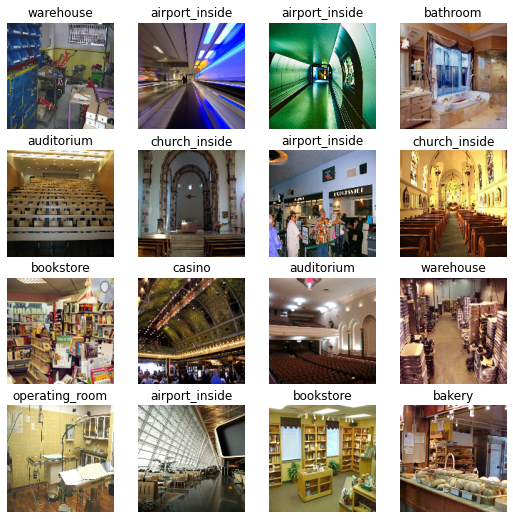

In [ ]:
# Checking training data
plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

### Data Augmentation

Now, creating data augmentation layer. I have selected only relevant data augmentation techniques for current scenario.

In [ ]:
# ## Creating data augmentation layer
augmentation_layer= Sequential(
  [tf.keras.layers.InputLayer(input_shape= (img_height, img_width, 3)),
   tf.keras.layers.RandomFlip('horizontal', seed= 42),
   tf.keras.layers.RandomRotation(0.2, fill_mode= 'wrap', seed= 42),
   tf.keras.layers.RandomZoom(0.2, seed= 42),
   tf.keras.layers.RandomTranslation(.2, .2, fill_mode='wrap', interpolation='bilinear', seed= 42),
   tf.keras.layers.RandomContrast(0.2, seed= 42)]
   )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


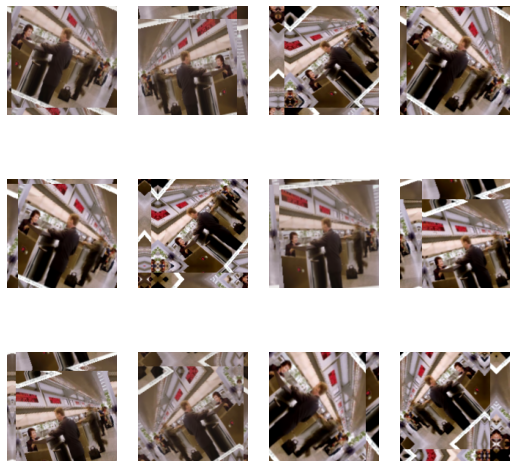

In [ ]:
# Plotting different augmented version of a random image from training dataset
plt.figure(figsize=(9, 9))
a= np.random.randint(42)
for images, labels in train_ds.take(1):
    for i in range(12):
      aug_img= augmentation_layer(images)
      ax = plt.subplot(3, 4, i + 1)
      plt.imshow(aug_img[a].numpy().astype(np.int32))
      plt.axis('off')

## Model building

### InceptionV3 Finetuning

First trying transfer learning using InceptionV3 architecture with imagenet pretrained weights. I have removed the default output softmax layer of InceptionV3. I have kept First 249 layers weights as it is. Trained layer 249 to last layer on training dataset. Added a Flatten layer, Dropout layers, 2 hidden dense layers and output dense layer with 10 neurons and softmax as activation.

I will use label encoding instead of one hot encoding to optimize memory utilization. So my loss function will be: sparse_categorical_entropy and my metric will be sparse_categorical_accuracy.

In [ ]:
# Creating function to fine tune InceptionV3
def inceptionv3(inp_shape, dropout_rate, train_layers_after):
    inceptionv3= InceptionV3(weights= 'imagenet', include_top= False)
    for layer in inceptionv3.layers[:train_layers_after]:
      layer.trainable= False
    input_layer= Input(shape= inp_shape)
    data_aug_layer= augmentation_layer(input_layer)
    norm_layer= tf.keras.layers.Rescaling(1./255)(data_aug_layer)
    cnn_layers= inceptionv3(norm_layer)
    flatten_layer= Flatten()(cnn_layers)
    dropout_layer1= Dropout(dropout_rate)(flatten_layer)
    dense_layer= Dense(1024, activation= 'relu', kernel_initializer= 'he_normal', kernel_regularizer='l2')(dropout_layer1)
    dropout_layer2= Dropout(dropout_rate)(dense_layer)
    dense_layer_1= Dense(512, activation= 'relu', kernel_initializer= 'he_normal', kernel_regularizer='l2')(dropout_layer2)
    dropout_layer3= Dropout(dropout_rate)(dense_layer_1)
    output_layer= Dense(10, activation= 'softmax')(dropout_layer3)
    model= Model(input_layer, output_layer)
    model.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics= ['sparse_categorical_accuracy'])
    return model

In [ ]:
# Creating model
inp_shape= (150, 150, 3)
dropout_rate= .25
train_layers_after= 249
incv3_model= inceptionv3(inp_shape, dropout_rate, train_layers_after)
incv3_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dropout_16 (Dropout)        (None, 18432)             0         
                                                                 
 dense_16 (Dense)            (None, 1024)              1887

In [ ]:
# Loading data into cache to overcome data bottleneck during training.
AUTOTUNE= tf.data.AUTOTUNE
AUTOTUNE= tf.data.experimental.AUTOTUNE

# Shuffling data before starting of each epoch
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size= AUTOTUNE)
val_ds= val_ds.cache().prefetch(buffer_size= AUTOTUNE)

In [ ]:
# Setting callbacks

base_path= '/content/drive/MyDrive/colab_data/indoorCVPR/models/'

filepath= base_path + 'model-{epoch:05d}-{loss:.5f}-{sparse_categorical_accuracy:.5f}-{val_loss:.5f}-{val_sparse_categorical_accuracy:.5f}.h5'

checkpoint= ModelCheckpoint(filepath, monitor= 'val_sparse_categorical_accuracy', verbose= 1,
                            save_best_only= True, save_weights_only= False, mode= 'auto')

LR= ReduceLROnPlateau(monitor= 'val_loss', factor= 0.1, patience= 30, verbose= 1)
callbacks_list= [checkpoint, LR]

In [ ]:
# Model training
epochs= 200
steps_per_epoch= math.ceil(2652/batch_size)
validation_steps= math.ceil(663/batch_size)

history= incv3_model.fit(train_ds, validation_data= val_ds, steps_per_epoch= steps_per_epoch, epochs= epochs, callbacks= callbacks_list, validation_steps= validation_steps)

Epoch 1/200
42/42 [==============================] - ETA: 0s - loss: 15.8288 - sparse_categorical_accuracy: 0.5735
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.74661, saving model to /content/drive/MyDrive/colab_data/indoorCVPR/models/model-00001-15.82881-0.57353-10.33403-0.74661.h5
42/42 [==============================] - 6s 145ms/step - loss: 15.8288 - sparse_categorical_accuracy: 0.5735 - val_loss: 10.3340 - val_sparse_categorical_accuracy: 0.7466 - lr: 0.0010
Epoch 2/200
42/42 [==============================] - ETA: 0s - loss: 7.6535 - sparse_categorical_accuracy: 0.6799
Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.74661
42/42 [==============================] - 3s 75ms/step - loss: 7.6535 - sparse_categorical_accuracy: 0.6799 - val_loss: 6.1165 - val_sparse_categorical_accuracy: 0.6637 - lr: 0.0010
Epoch 3/200
42/42 [==============================] - ETA: 0s - loss: 4.6356 - sparse_categorical_accuracy: 0.7455
Epoch 00003: val_sparse_c

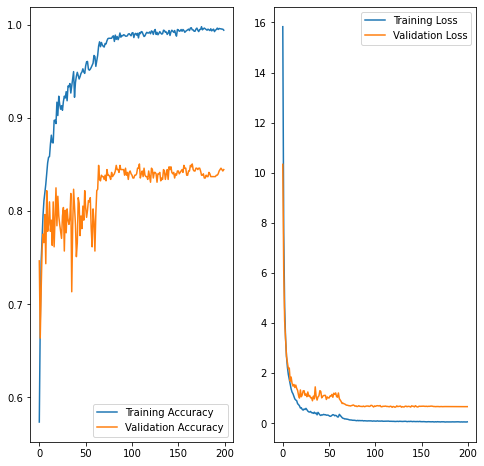

In [ ]:
acc= history.history['sparse_categorical_accuracy']
val_acc= history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

- Best Epoch: 109 (model-00109-0.08159-0.99170-0.67942-0.85068.h5)
- **Training: loss: .08 - categorical_accuracy: 0.99**
- **Validation: val_loss: .68 - val_sparse_categorical_accuracy: 0.85**


### Xception Finetunning

Used almost same architecture as previous one, only used Xception as our cnn architecture instead of InceptionV3. Removed output softmax layer of Xception architecture and finetunned Xception from layer 114 to end layer. Then I have added custom layers as previous.

In [ ]:
# Creating function to fine tune Xception
def xception_cnn(inp_shape, dropout_rate, train_layers_after):
    xcp= Xception(weights= 'imagenet', include_top= False)
    for layer in xcp.layers[:train_layers_after]:
      layer.trainable= False
    input_layer= Input(shape= inp_shape)
    data_aug_layer= augmentation_layer(input_layer)
    norm_layer= tf.keras.layers.Rescaling(1./255)(data_aug_layer)
    cnn_layers= xcp(norm_layer)
    flatten_layer= Flatten()(cnn_layers)
    dropout_layer1= Dropout(dropout_rate)(flatten_layer)
    dense_layer= Dense(1024, activation= 'relu', kernel_initializer= 'he_normal', kernel_regularizer='l2')(dropout_layer1)
    dropout_layer2= Dropout(dropout_rate)(dense_layer)
    dense_layer_1= Dense(512, activation= 'relu', kernel_initializer= 'he_normal', kernel_regularizer='l2')(dropout_layer2)
    dropout_layer3= Dropout(dropout_rate)(dense_layer_1)
    output_layer= Dense(10, activation= 'softmax')(dropout_layer3)
    model= Model(input_layer, output_layer)
    model.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics= ['sparse_categorical_accuracy'])
    return model

In [ ]:
# Creating model
inp_shape= (150, 150, 3)
dropout_rate= .25
train_layers_after= 114
xcp_model= xception_cnn(inp_shape, dropout_rate, train_layers_after)
xcp_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 flatten_3 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_22 (Dropout)        (None, 51200)             0         
                                                                 
 dense_22 (Dense)            (None, 1024)              524

In [ ]:
# Model training
epochs= 200
steps_per_epoch= math.ceil(2652/batch_size)
validation_steps= math.ceil(663/batch_size)

history= xcp_model.fit(train_ds, validation_data= val_ds, steps_per_epoch= steps_per_epoch, epochs= epochs, callbacks= callbacks_list, validation_steps= validation_steps)

Epoch 1/200
42/42 [==============================] - ETA: 0s - loss: 21.6196 - sparse_categorical_accuracy: 0.2202
Epoch 00001: val_sparse_categorical_accuracy did not improve from 0.85068
42/42 [==============================] - 52s 142ms/step - loss: 21.6196 - sparse_categorical_accuracy: 0.2202 - val_loss: 9.6215 - val_sparse_categorical_accuracy: 0.3605 - lr: 0.0010
Epoch 2/200
42/42 [==============================] - ETA: 0s - loss: 6.4122 - sparse_categorical_accuracy: 0.4295
Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.85068
42/42 [==============================] - 5s 122ms/step - loss: 6.4122 - sparse_categorical_accuracy: 0.4295 - val_loss: 4.9210 - val_sparse_categorical_accuracy: 0.5400 - lr: 0.0010
Epoch 3/200
42/42 [==============================] - ETA: 0s - loss: 3.6127 - sparse_categorical_accuracy: 0.6233
Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.85068
42/42 [==============================] - 5s 122ms/step - loss: 3.6127

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


42/42 [==============================] - 8s 185ms/step - loss: 0.7007 - sparse_categorical_accuracy: 0.8752 - val_loss: 0.8112 - val_sparse_categorical_accuracy: 0.8627 - lr: 0.0010
Epoch 16/200
42/42 [==============================] - ETA: 0s - loss: 0.6955 - sparse_categorical_accuracy: 0.8846
Epoch 00016: val_sparse_categorical_accuracy did not improve from 0.86275
42/42 [==============================] - 5s 122ms/step - loss: 0.6955 - sparse_categorical_accuracy: 0.8846 - val_loss: 0.8600 - val_sparse_categorical_accuracy: 0.8326 - lr: 0.0010
Epoch 17/200
42/42 [==============================] - ETA: 0s - loss: 0.6100 - sparse_categorical_accuracy: 0.8842
Epoch 00017: val_sparse_categorical_accuracy did not improve from 0.86275
42/42 [==============================] - 5s 122ms/step - loss: 0.6100 - sparse_categorical_accuracy: 0.8842 - val_loss: 0.9421 - val_sparse_categorical_accuracy: 0.8084 - lr: 0.0010
Epoch 18/200
42/42 [==============================] - ETA: 0s - loss: 0.6158

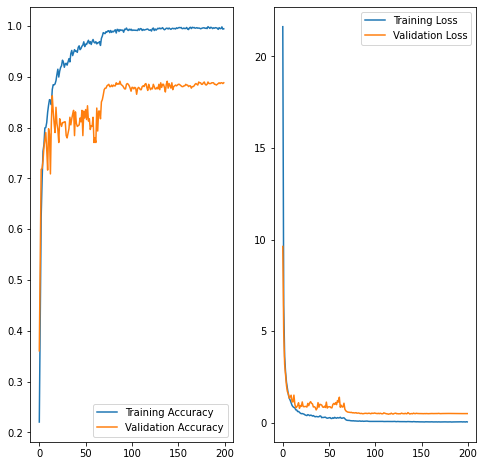

In [ ]:
acc= history.history['sparse_categorical_accuracy']
val_acc= history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

- Best Epoch: 88 (model-00088-0.07750-0.99321-0.49403-0.89140.h5)
- **Training: loss: .775 - categorical_accuracy: 0.993**
- **Validation: val_loss: .494 - val_sparse_categorical_accuracy: 0.891**


## Inference Script

In [ ]:
# Combining both the models for inference
final_model1= tf.keras.models.load_model('/content/drive/MyDrive/colab_data/models/model-00088-0.07750-0.99321-0.49403-0.89140.h5')
final_model2=  tf.keras.models.load_model('/content/drive/MyDrive/colab_data/models/model-00109-0.08159-0.99170-0.67942-0.85068.h5')
models= [final_model1, final_model2]

In [ ]:
# Single inference function
def single_inference(path, models):
  classes= ['airport_inside', 'auditorium', 'bakery', 'bathroom', 'bookstore', 'casino', 'church_inside', 'grocerystore', 'operating_room', 'warehouse']
  img= cv2.imread(path, cv2.IMREAD_UNCHANGED)
  cv2_imshow(img)
  img= cv2.resize(img, (150, 150), interpolation = cv2.INTER_AREA)
  img= img.reshape((1,150,150,3))
  pred1= models[0].predict(img)
  pred2= models[1].predict(img)
  pred= (pred1+pred2)/2
  print ('Predicted class:', classes[np.argmax(pred)])

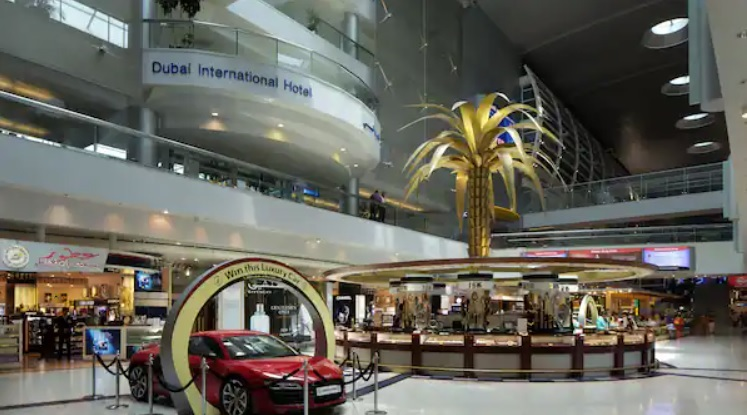

Predicted class: airport_inside


In [ ]:
# Predicting a random image from internet
single_inference('/content/test1.jpg', models)

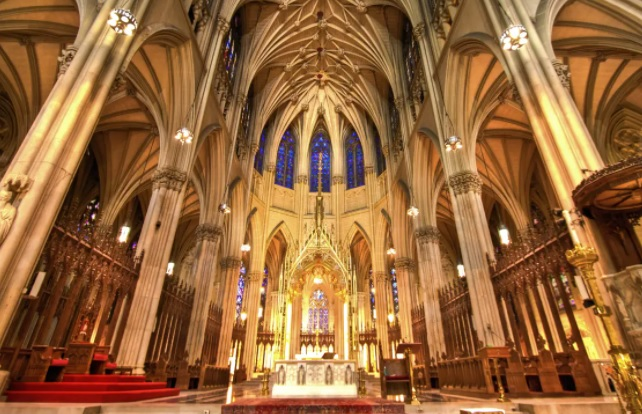

Predicted class: church_inside


In [ ]:
# Predicting a random image from internet
single_inference('/content/test2.jpg', models)

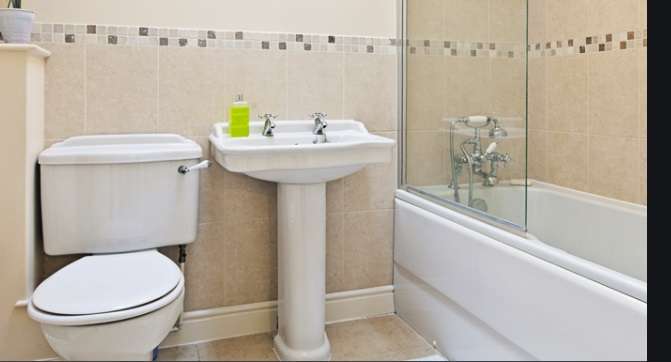

Predicted class: bathroom


In [ ]:
# Predicting a random image from internet
single_inference('/content/test3.jpg', models)

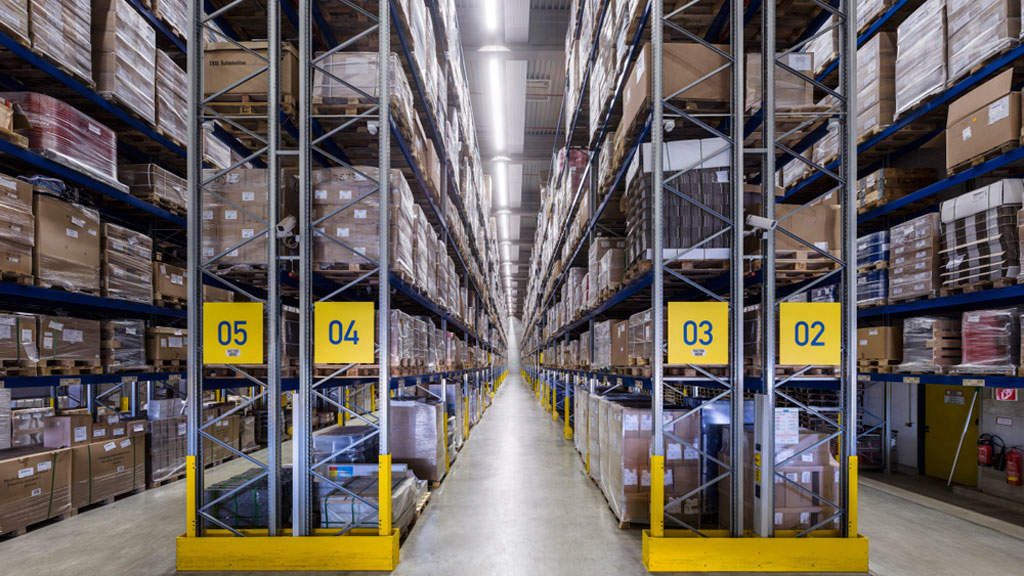

Predicted class: warehouse


In [ ]:
# Predicting a random image from internet
single_inference('/content/test4.jpg', models)